#Introducting Metro malls : A strategy to boost bart revenue 
ใช้ข้อมูลตั้งแต่ปี 2017 - 2022 
โดยใช้ SARIMA 

File uploaded to /FileStore/tables/bart2017-1.csv
File uploaded to /FileStore/tables/bart2018-1.csv
File uploaded to /FileStore/tables/bart2020-1.csv
File uploaded to /FileStore/tables/bart2019-1.csv
File uploaded to /FileStore/tables/bart2021-3.csv
File uploaded to /FileStore/tables/bart2022-2.csv

In [0]:
pip install pyspark

Python interpreter will be restarted.
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840651 sha256=5ec6eb6ac340d7b12e1e834401b10ee4bb4e47f57eed54ad6c17947d0cf95f80
  Stored in directory: /root/.cache/pip/wheels/2e/d2/18/6f4f20e8332359f7fffceb6828edcc80ef96f86744192a7bb9
Successfully built pyspark
Python interpreter will be restarted.


In [0]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("BART Analysis").getOrCreate()


file_paths = [
    "/FileStore/tables/bart2017-1.csv",
    "/FileStore/tables/bart2018-1.csv",
    "/FileStore/tables/bart2019-1.csv",
    "/FileStore/tables/bart2020-1.csv",
    "/FileStore/tables/bart2021-3.csv",
    "/FileStore/tables/bart2022-2.csv"
]


df_combined = None
for file_path in file_paths:
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    if df_combined is None:
        df_combined = df
    else:
        df_combined = df_combined.union(df)


print("ข้อมูลเบื้องต้นหลังการรวม:")
df_combined.show(5)


ข้อมูลเบื้องต้นหลังการรวม:
+----------+----+--------------+-------------------+----------+
|      Date|Hour|Origin Station|Destination Station|Trip Count|
+----------+----+--------------+-------------------+----------+
|2017-01-01|   0|          12TH|               19TH|         1|
|2017-01-01|   0|          12TH|               24TH|         2|
|2017-01-01|   0|          12TH|               BAYF|         1|
|2017-01-01|   0|          12TH|               CIVC|         5|
|2017-01-01|   0|          12TH|               COLS|         2|
+----------+----+--------------+-------------------+----------+
only showing top 5 rows



In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofweek, when, to_date
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd


spark = SparkSession.builder \
    .appName("BART Ridership Analysis") \
    .getOrCreate()


file_paths = [
    "/FileStore/tables/bart2017-1.csv",
    "/FileStore/tables/bart2018-1.csv",
    "/FileStore/tables/bart2019-1.csv",
    "/FileStore/tables/bart2020-1.csv",
    "/FileStore/tables/bart2021-3.csv",
    "/FileStore/tables/bart2022-2.csv"
]


df = None
for file_path in file_paths:
    temp_df = spark.read.csv(file_path, header=True, inferSchema=True)
    if df is None:
        df = temp_df
    else:
        df = df.union(temp_df)


df = df.withColumn("Date", to_date(col("Date")))


df = df.withColumn("Day_of_Week", dayofweek(col("Date")))


df = df.withColumn("Day_Type", when(col("Day_of_Week").isin([1, 7]), "Weekend").otherwise("Weekday"))


daily_station_counts = df.groupBy("Date", "Destination Station").agg({"Trip Count": "sum"}).withColumnRenamed("sum(Trip Count)", "Total_Trip_Count")


top_stations = daily_station_counts.groupBy("Destination Station") \
    .agg({"Total_Trip_Count": "sum"}).orderBy(col("sum(Total_Trip_Count)").desc()).limit(10).toPandas()

top_station_names = top_stations['Destination Station'].tolist()


top_daily_counts = daily_station_counts.filter(col("Destination Station").isin(top_station_names)).toPandas()


top_daily_counts.set_index('Date', inplace=True)
top_daily_counts = top_daily_counts.sort_index()


results = {}
for station in top_station_names:
    station_data = top_daily_counts[top_daily_counts['Destination Station'] == station]['Total_Trip_Count']
    
    
    model = SARIMAX(station_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # ปรับพารามิเตอร์ตามความเหมาะสม
    results[station] = model.fit(disp=False)


for station, result in results.items():
    print(f"--- SARIMA model for {station} ---")
    print(result.summary())


/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  se

--- SARIMA model for EMBR ---
                                     SARIMAX Results                                      
Dep. Variable:                   Total_Trip_Count   No. Observations:                 2187
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -23781.996
Date:                            Thu, 17 Oct 2024   AIC                          47573.993
Time:                                    12:50:14   BIC                          47602.414
Sample:                                         0   HQIC                         47584.385
                                           - 2187                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9728      0.007   -144.679      0.000      -0.986      -0.960
ma.L1

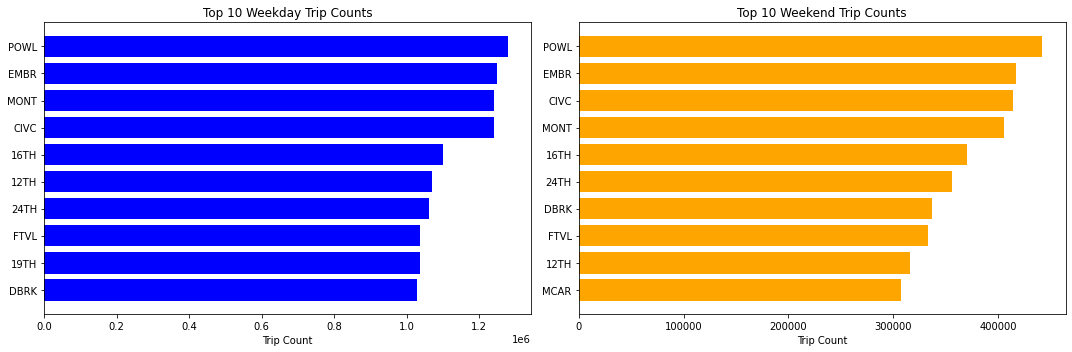

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofweek, when, to_date, count
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("BART Ridership Analysis") \
    .getOrCreate()


df = df.withColumn("Day_of_Week", dayofweek(col("Date")))


weekday_counts = df.filter(col("Day_of_Week").isin([2, 3, 4, 5, 6])) \
    .groupBy("Destination Station") \
    .agg(count("Trip Count").alias("count")) \
    .orderBy(col("count").desc())

weekend_counts = df.filter(col("Day_of_Week").isin([1, 7])) \
    .groupBy("Destination Station") \
    .agg(count("Trip Count").alias("count")) \
    .orderBy(col("count").desc())


top_weekday_counts = weekday_counts.limit(10)
top_weekend_counts = weekend_counts.limit(10)


top_weekday_counts_pd = top_weekday_counts.toPandas()
top_weekend_counts_pd = top_weekend_counts.toPandas()


fig, axs = plt.subplots(1, 2, figsize=(15, 5))


axs[0].barh(top_weekday_counts_pd['Destination Station'], top_weekday_counts_pd['count'], color='blue')
axs[0].set_title('Top 10 Weekday Trip Counts')
axs[0].set_xlabel('Trip Count')
axs[0].invert_yaxis()  

axs[1].barh(top_weekend_counts_pd['Destination Station'], top_weekend_counts_pd['count'], color='orange')
axs[1].set_title('Top 10 Weekend Trip Counts')
axs[1].set_xlabel('Trip Count')
axs[1].invert_yaxis()  

plt.tight_layout()
plt.show()



Seasonal

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


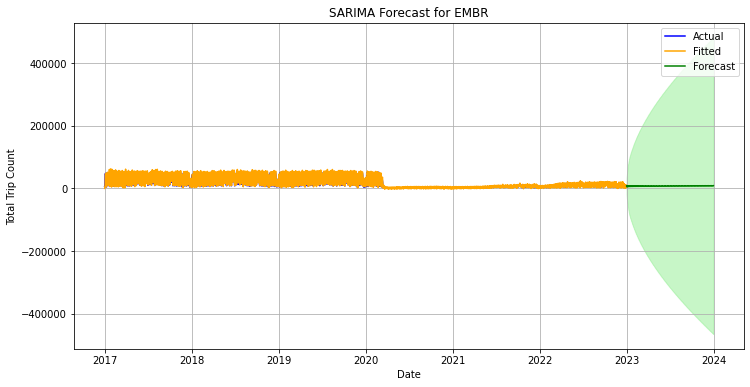

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


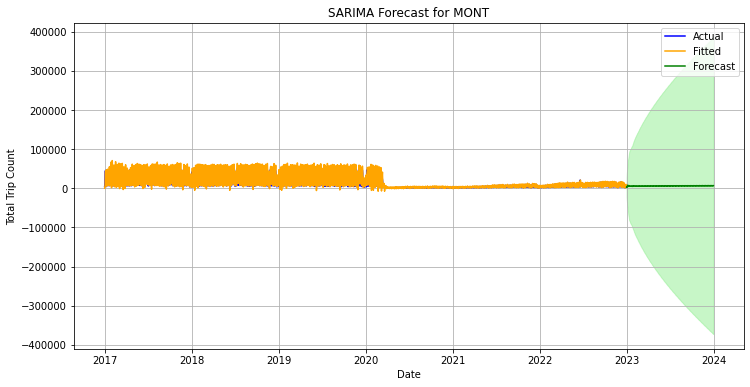

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


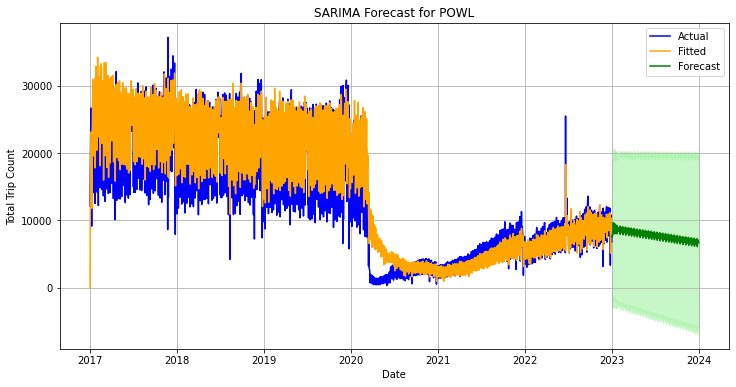

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


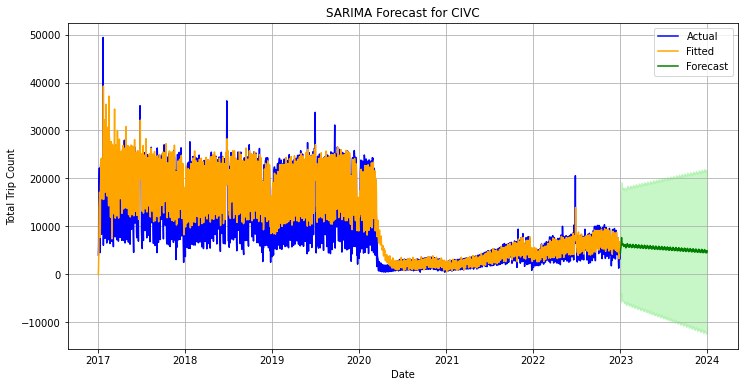

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


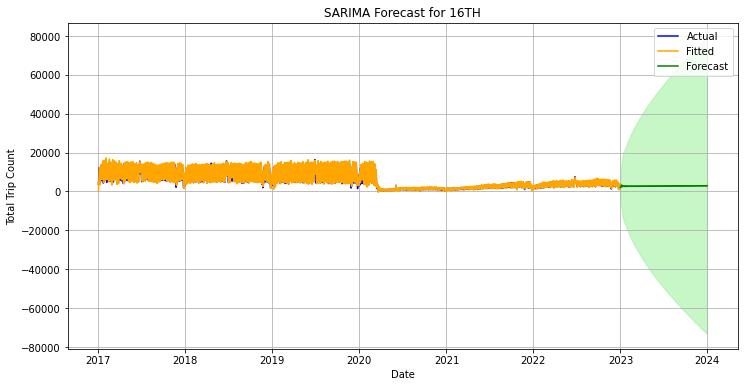

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


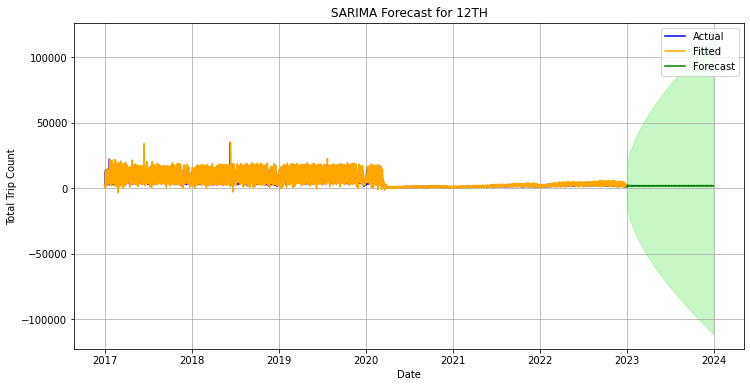

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


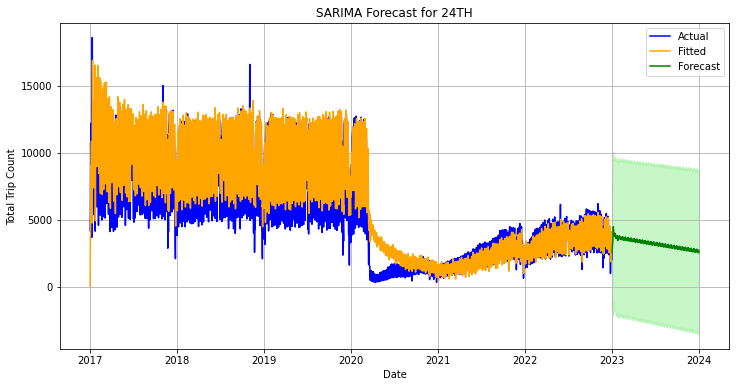

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


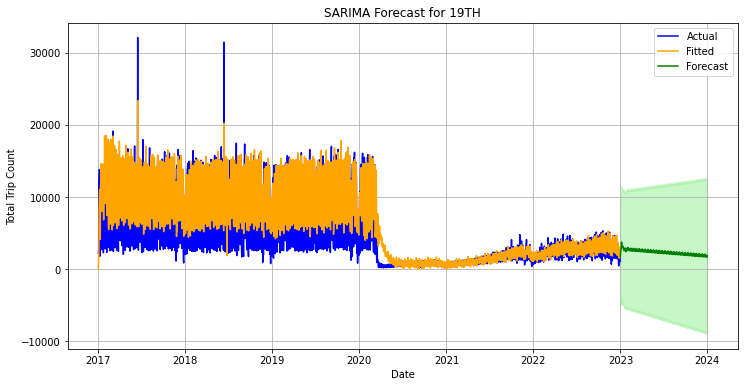

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


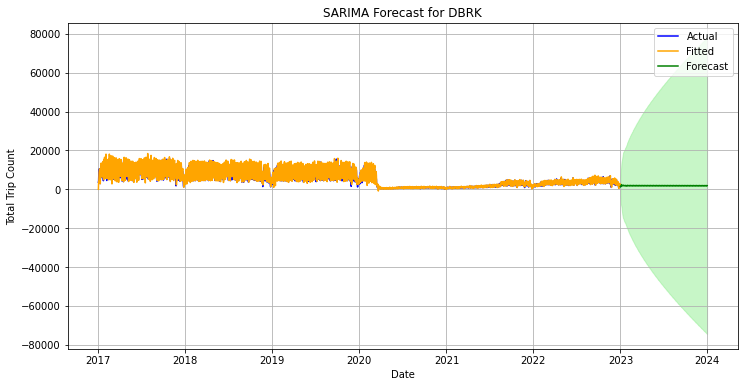

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


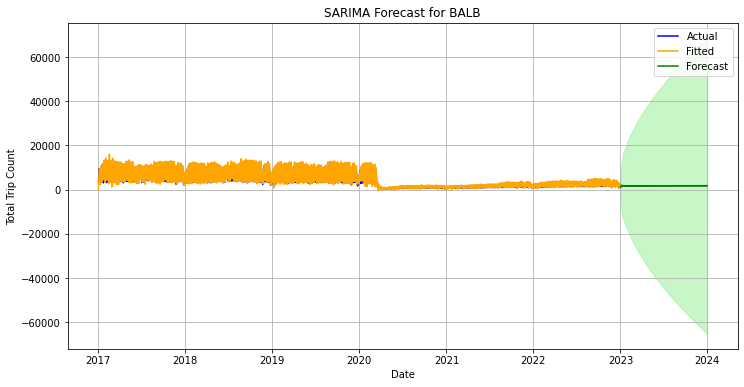

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


forecast_horizon = 365  


for station, result in results.items():

    station_data = top_daily_counts[top_daily_counts['Destination Station'] == station]['Total_Trip_Count']
    

    plt.figure(figsize=(12, 6))
    

    plt.plot(station_data.index, station_data.values, label='Actual', color='blue')
    
 
    fitted_values = result.fittedvalues
    plt.plot(station_data.index, fitted_values, label='Fitted', color='orange')
    
 
    forecast = result.get_forecast(steps=forecast_horizon)
    forecast_index = pd.date_range(start=station_data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()
    

    plt.plot(forecast_index, forecast_values, label='Forecast', color='green')
    

    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgreen', alpha=0.5)

 
    plt.title(f'SARIMA Forecast for {station}')
    plt.xlabel('Date')
    plt.ylabel('Total Trip Count')
    plt.legend() 
    plt.grid()
    
    plt.show()


Seasonal
Weekday and Weeekend

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(date

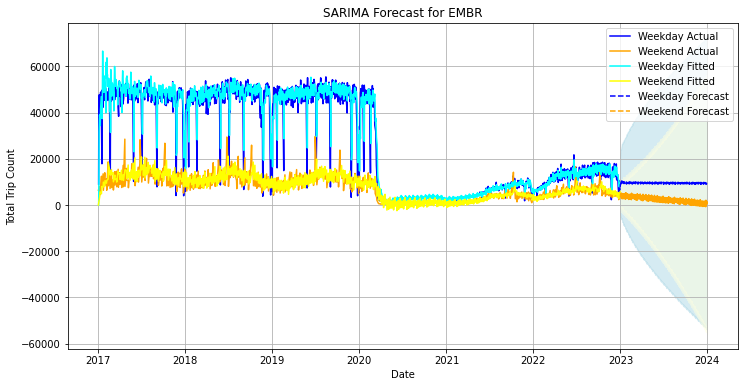

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


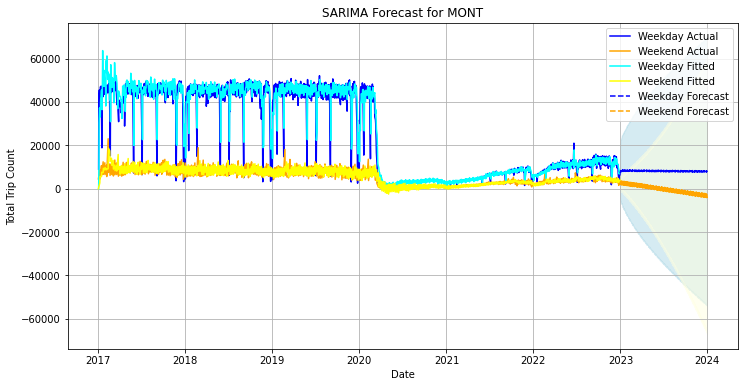

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


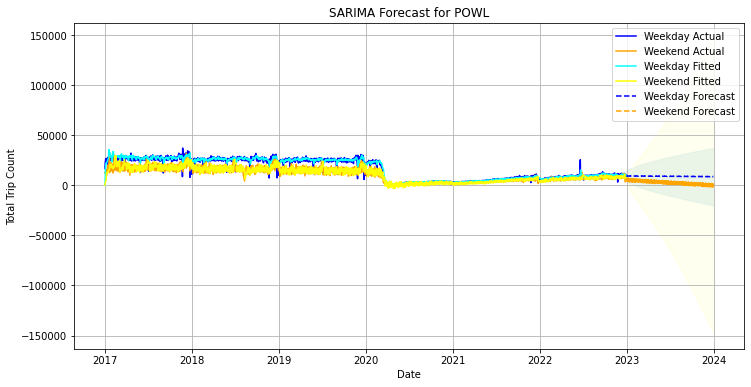

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


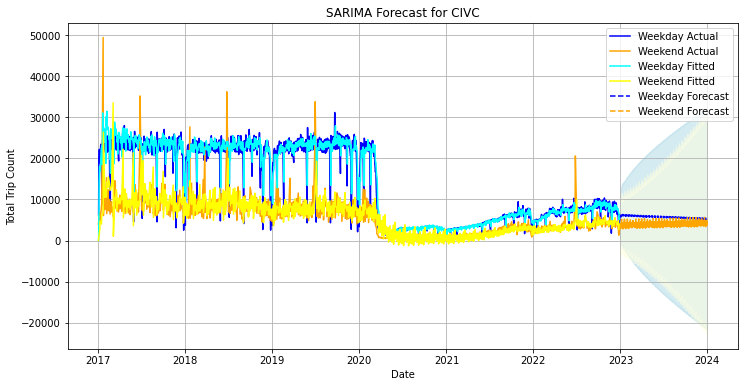

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


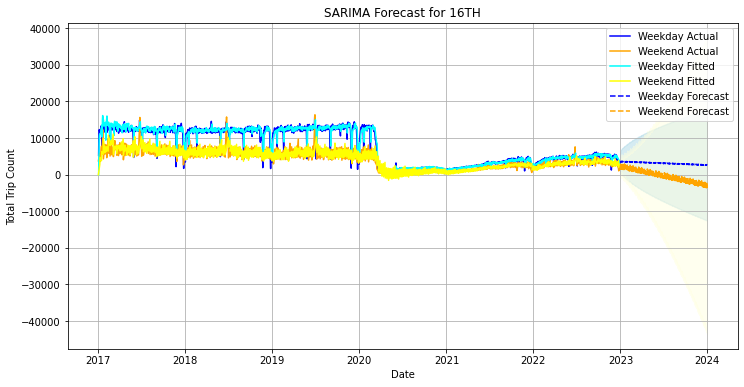

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


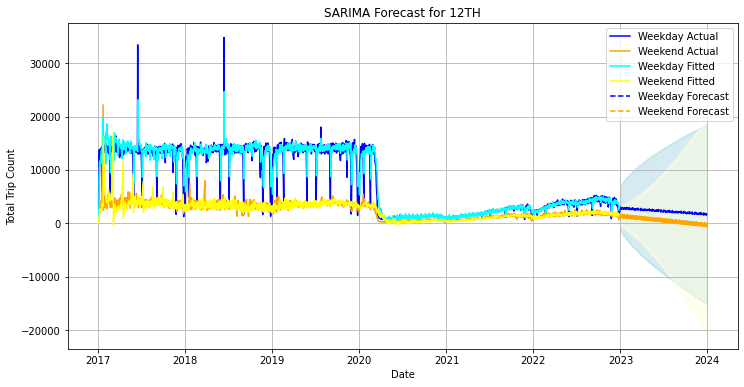

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


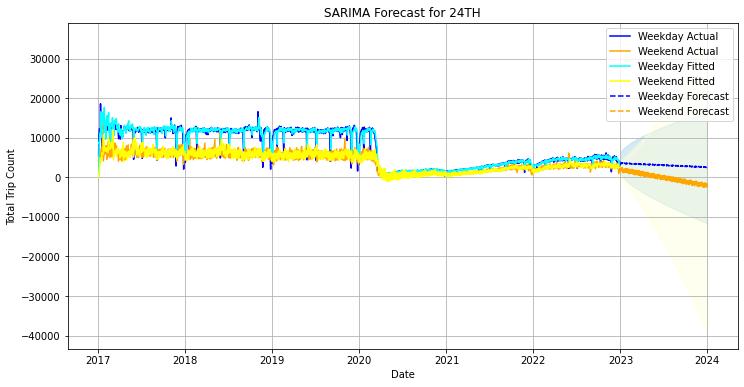

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


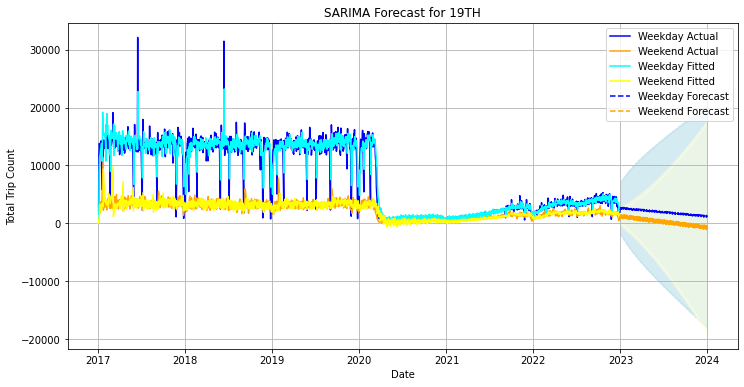

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


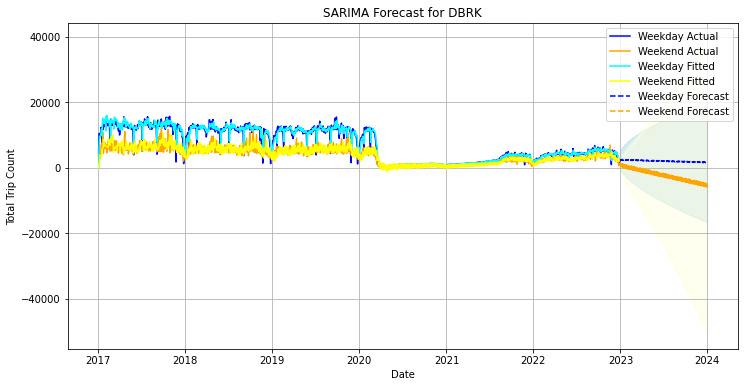

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


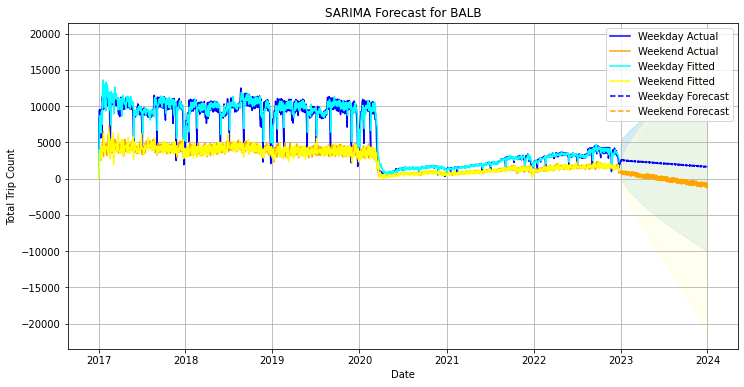

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofweek, when, to_date
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("BART Ridership Analysis") \
    .getOrCreate()


file_paths = [
    "/FileStore/tables/bart2017-1.csv",
    "/FileStore/tables/bart2018-1.csv",
    "/FileStore/tables/bart2019-1.csv",
    "/FileStore/tables/bart2020-1.csv",
    "/FileStore/tables/bart2021-3.csv",
    "/FileStore/tables/bart2022-2.csv"
]


df_list = [spark.read.csv(file_path, header=True, inferSchema=True) for file_path in file_paths]
df = df_list[0]
for other_df in df_list[1:]:
    df = df.union(other_df)


df = df.withColumn("Date", to_date(col("Date")))


df = df.withColumn("Day_of_Week", dayofweek(col("Date")))


df = df.withColumn("Day_Type", when(col("Day_of_Week").isin([1, 7]), "Weekend").otherwise("Weekday"))


daily_station_counts = df.groupBy("Date", "Destination Station").agg({"Trip Count": "sum"}) \
    .withColumnRenamed("sum(Trip Count)", "Total_Trip_Count")


top_stations = daily_station_counts.groupBy("Destination Station") \
    .agg({"Total_Trip_Count": "sum"}).orderBy(col("sum(Total_Trip_Count)").desc()).limit(10).toPandas()

top_station_names = top_stations['Destination Station'].tolist()


top_daily_counts = daily_station_counts.filter(col("Destination Station").isin(top_station_names)).toPandas()


day_type_df = df.select("Date", "Destination Station", "Day_Type").distinct().toPandas()
top_daily_counts = pd.merge(top_daily_counts, day_type_df, on=["Date", "Destination Station"], how="left")


top_daily_counts.set_index('Date', inplace=True)
top_daily_counts = top_daily_counts.sort_index()


weekday_counts = top_daily_counts[top_daily_counts['Day_Type'] == 'Weekday']
weekend_counts = top_daily_counts[top_daily_counts['Day_Type'] == 'Weekend']


results = {'Weekday': {}, 'Weekend': {}}
for station in top_station_names:
  
    weekday_data = weekday_counts[weekday_counts['Destination Station'] == station]['Total_Trip_Count']
    model_weekday = SARIMAX(weekday_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results['Weekday'][station] = model_weekday.fit(disp=False)
    
 
    weekend_data = weekend_counts[weekend_counts['Destination Station'] == station]['Total_Trip_Count']
    model_weekend = SARIMAX(weekend_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results['Weekend'][station] = model_weekend.fit(disp=False)

forecast_horizon = 365  


for station in top_station_names:
  
    weekday_data = weekday_counts[weekday_counts['Destination Station'] == station]['Total_Trip_Count']
    weekend_data = weekend_counts[weekend_counts['Destination Station'] == station]['Total_Trip_Count']
    
    
    plt.figure(figsize=(12, 6))


    plt.plot(weekday_data.index, weekday_data.values, label='Weekday Actual', color='blue')
    
    
    plt.plot(weekend_data.index, weekend_data.values, label='Weekend Actual', color='orange')

   
    weekday_fitted = results['Weekday'][station].fittedvalues
    plt.plot(weekday_data.index, weekday_fitted, label='Weekday Fitted', color='cyan')


    weekend_fitted = results['Weekend'][station].fittedvalues
    plt.plot(weekend_data.index, weekend_fitted, label='Weekend Fitted', color='yellow')


    weekday_forecast = results['Weekday'][station].get_forecast(steps=forecast_horizon)
    forecast_index_weekday = pd.date_range(start=weekday_data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
    forecast_values_weekday = weekday_forecast.predicted_mean
    conf_int_weekday = weekday_forecast.conf_int()


    plt.plot(forecast_index_weekday, forecast_values_weekday, label='Weekday Forecast', color='blue', linestyle='dashed')


    plt.fill_between(forecast_index_weekday, conf_int_weekday.iloc[:, 0], conf_int_weekday.iloc[:, 1], color='lightblue', alpha=0.5)


    weekend_forecast = results['Weekend'][station].get_forecast(steps=forecast_horizon)
    forecast_index_weekend = pd.date_range(start=weekend_data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
    forecast_values_weekend = weekend_forecast.predicted_mean
    conf_int_weekend = weekend_forecast.conf_int()

    
    plt.plot(forecast_index_weekend, forecast_values_weekend, label='Weekend Forecast', color='orange', linestyle='dashed')


    plt.fill_between(forecast_index_weekend, conf_int_weekend.iloc[:, 0], conf_int_weekend.iloc[:, 1], color='lightyellow', alpha=0.5)


    plt.title(f'SARIMA Forecast for {station}')
    plt.xlabel('Date')
    plt.ylabel('Total Trip Count')
    plt.legend()
    plt.grid()
    

    plt.show()


In [0]:
Seasonal forecast Weekday

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(date

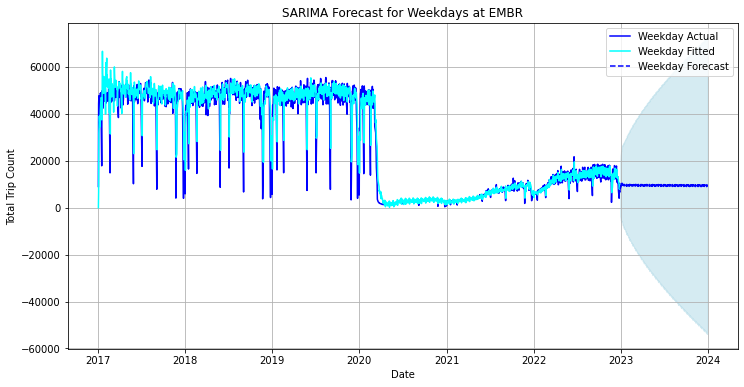

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


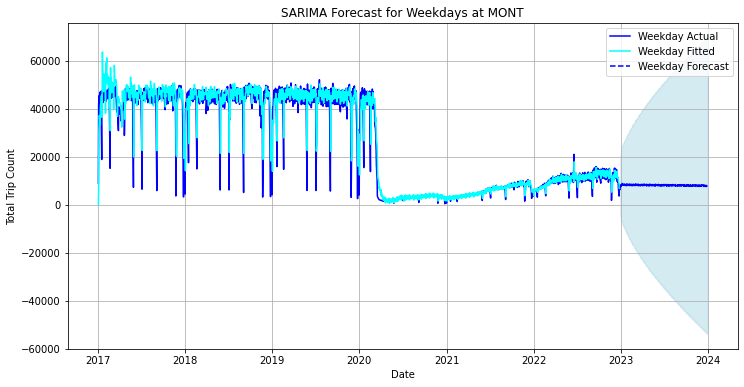

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


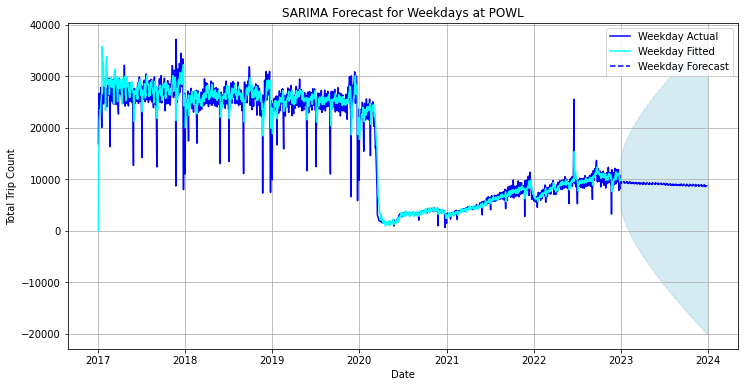

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


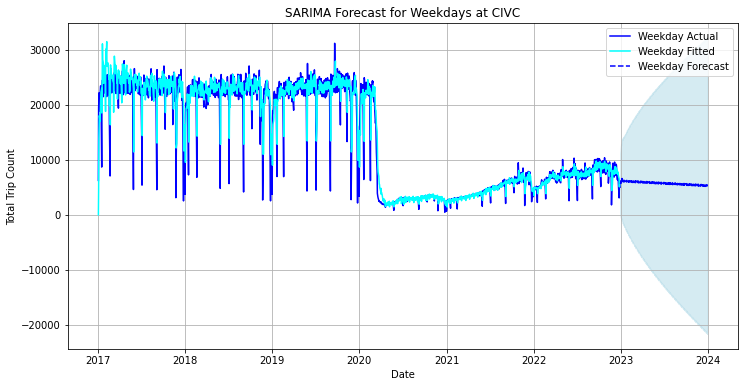

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


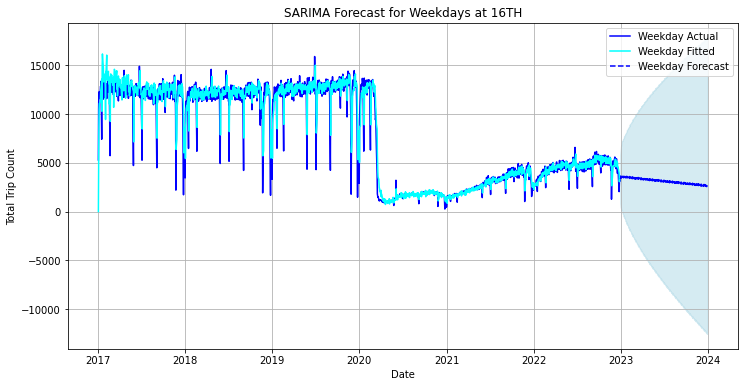

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


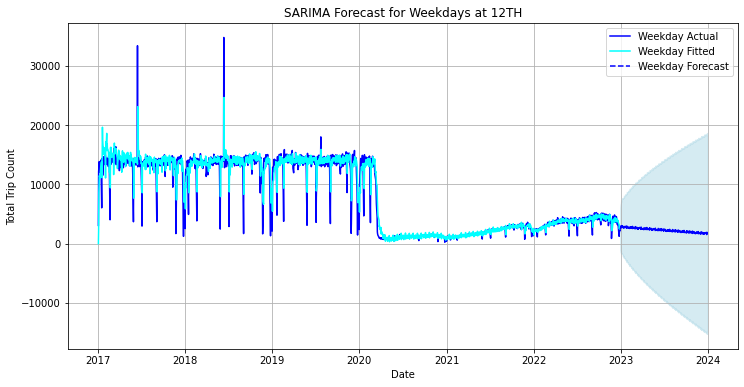

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


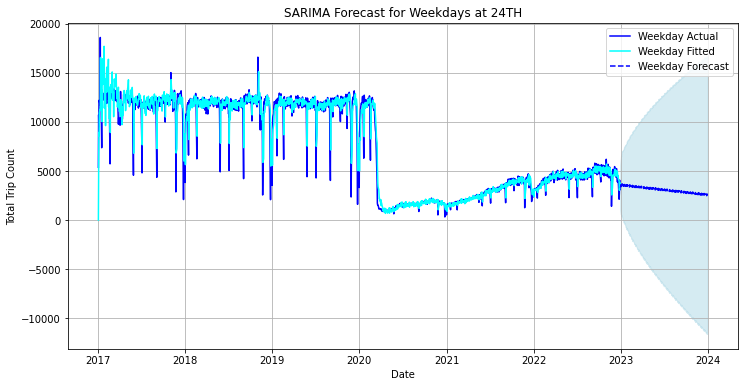

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


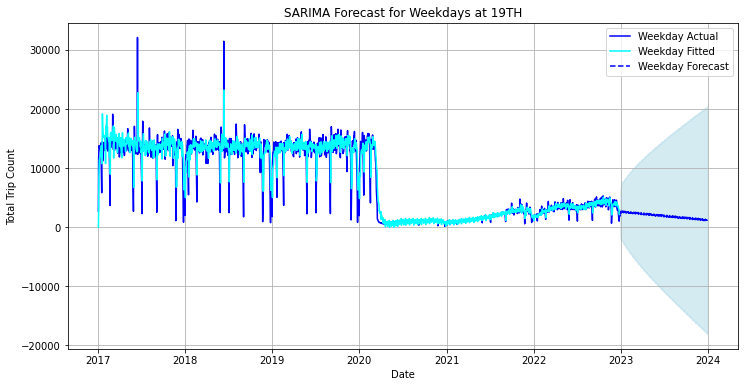

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


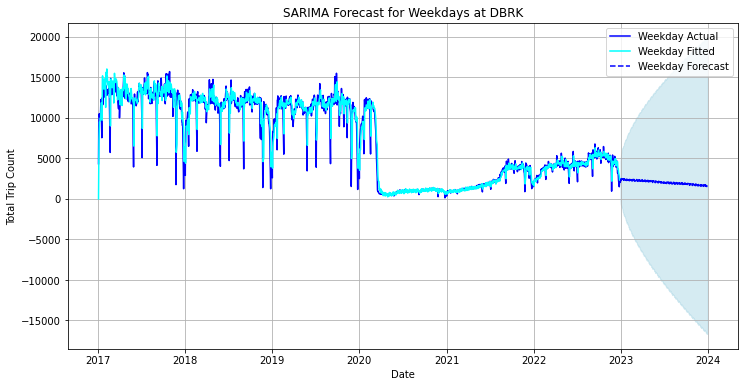

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


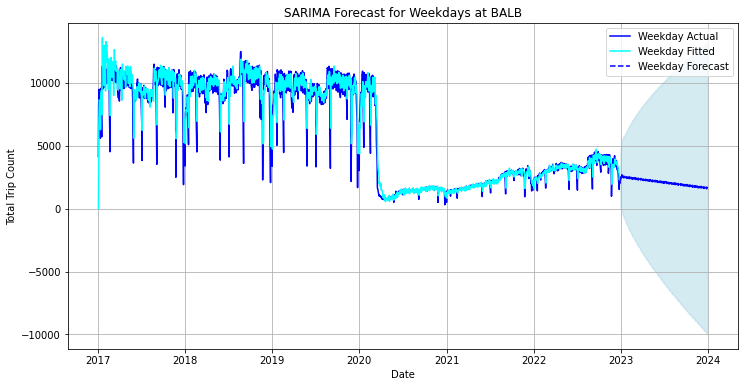

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofweek, when, to_date
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("BART Ridership Analysis") \
    .getOrCreate()


file_paths = [
    "/FileStore/tables/bart2017-1.csv",
    "/FileStore/tables/bart2018-1.csv",
    "/FileStore/tables/bart2019-1.csv",
    "/FileStore/tables/bart2020-1.csv",
    "/FileStore/tables/bart2021-3.csv",
    "/FileStore/tables/bart2022-2.csv"
]

df_list = [spark.read.csv(file_path, header=True, inferSchema=True) for file_path in file_paths]
df = df_list[0]
for other_df in df_list[1:]:
    df = df.union(other_df)


df = df.withColumn("Date", to_date(col("Date")))


df = df.withColumn("Day_of_Week", dayofweek(col("Date")))


df = df.withColumn("Day_Type", when(col("Day_of_Week").isin([1, 7]), "Weekend").otherwise("Weekday"))


daily_station_counts = df.groupBy("Date", "Destination Station").agg({"Trip Count": "sum"}) \
    .withColumnRenamed("sum(Trip Count)", "Total_Trip_Count")


top_stations = daily_station_counts.groupBy("Destination Station") \
    .agg({"Total_Trip_Count": "sum"}).orderBy(col("sum(Total_Trip_Count)").desc()).limit(10).toPandas()

top_station_names = top_stations['Destination Station'].tolist()


top_daily_counts = daily_station_counts.filter(col("Destination Station").isin(top_station_names)).toPandas()


day_type_df = df.select("Date", "Destination Station", "Day_Type").distinct().toPandas()
top_daily_counts = pd.merge(top_daily_counts, day_type_df, on=["Date", "Destination Station"], how="left")


top_daily_counts.set_index('Date', inplace=True)
top_daily_counts = top_daily_counts.sort_index()


weekday_counts = top_daily_counts[top_daily_counts['Day_Type'] == 'Weekday']


results_weekday = {}
for station in top_station_names:

    weekday_data = weekday_counts[weekday_counts['Destination Station'] == station]['Total_Trip_Count']
    model_weekday = SARIMAX(weekday_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results_weekday[station] = model_weekday.fit(disp=False)


forecast_horizon = 365  


for station in top_station_names:

    weekday_data = weekday_counts[weekday_counts['Destination Station'] == station]['Total_Trip_Count']
    

    plt.figure(figsize=(12, 6))


    plt.plot(weekday_data.index, weekday_data.values, label='Weekday Actual', color='blue')


    weekday_fitted = results_weekday[station].fittedvalues
    plt.plot(weekday_data.index, weekday_fitted, label='Weekday Fitted', color='cyan')


    weekday_forecast = results_weekday[station].get_forecast(steps=forecast_horizon)
    forecast_index_weekday = pd.date_range(start=weekday_data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
    forecast_values_weekday = weekday_forecast.predicted_mean
    conf_int_weekday = weekday_forecast.conf_int()


    plt.plot(forecast_index_weekday, forecast_values_weekday, label='Weekday Forecast', color='blue', linestyle='dashed')

  
    plt.fill_between(forecast_index_weekday, conf_int_weekday.iloc[:, 0], conf_int_weekday.iloc[:, 1], color='lightblue', alpha=0.5)


    plt.title(f'SARIMA Forecast for Weekdays at {station}')
    plt.xlabel('Date')
    plt.ylabel('Total Trip Count')
    plt.legend()
    plt.grid()
    

    plt.show()


Seasonal forecast Weekend

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  se

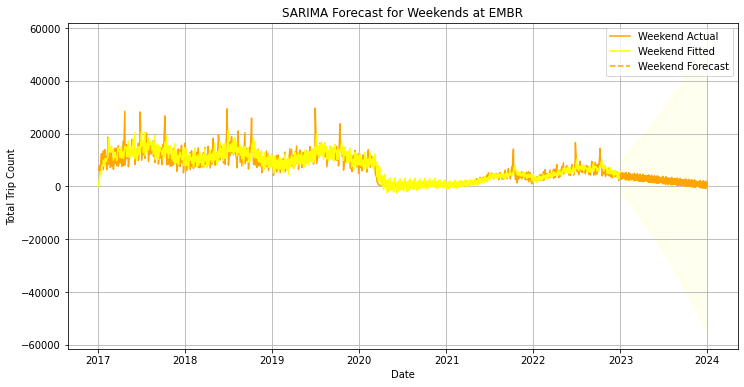

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


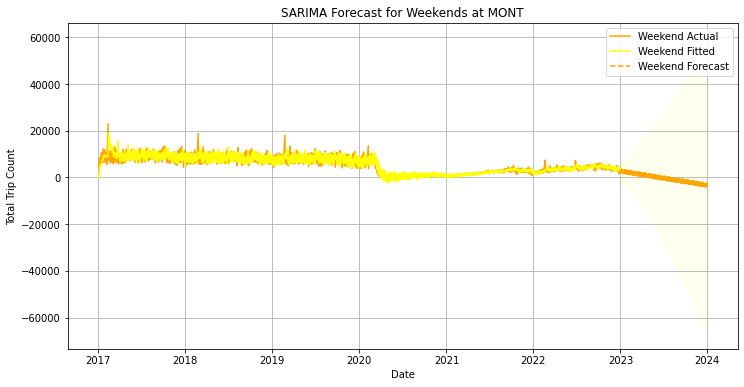

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


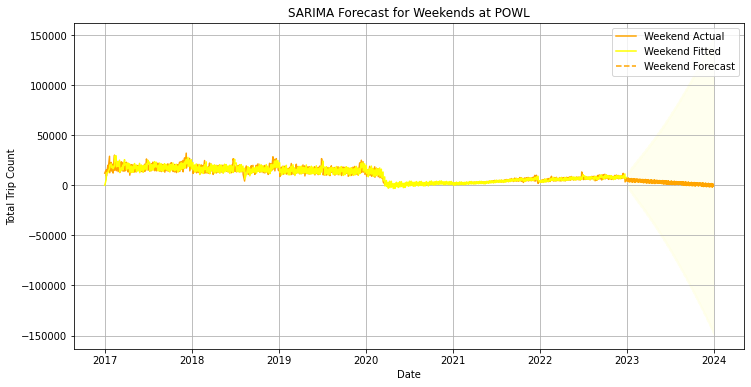

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


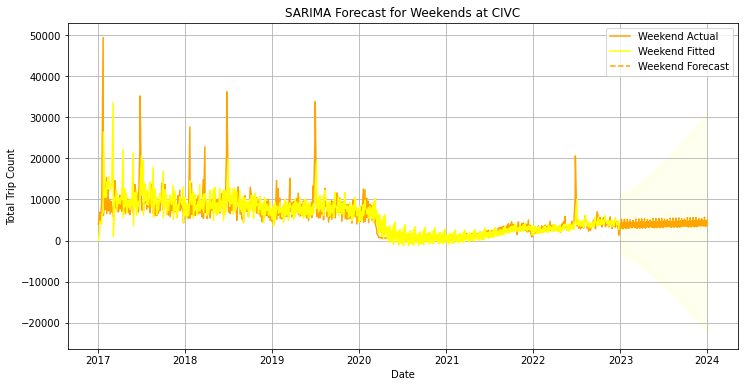

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


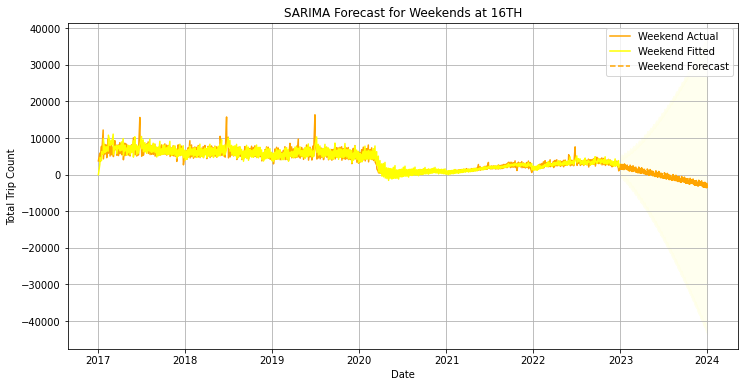

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


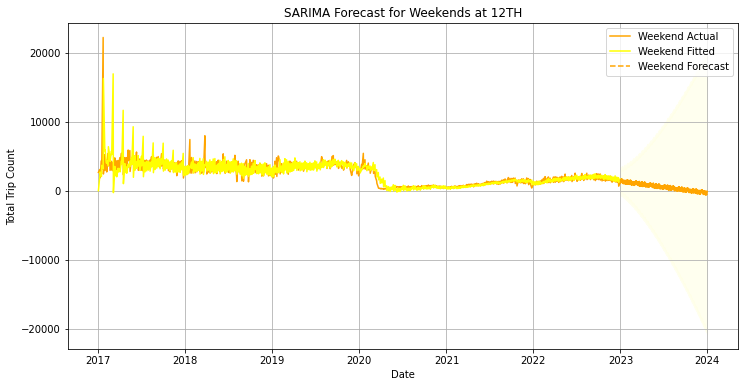

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


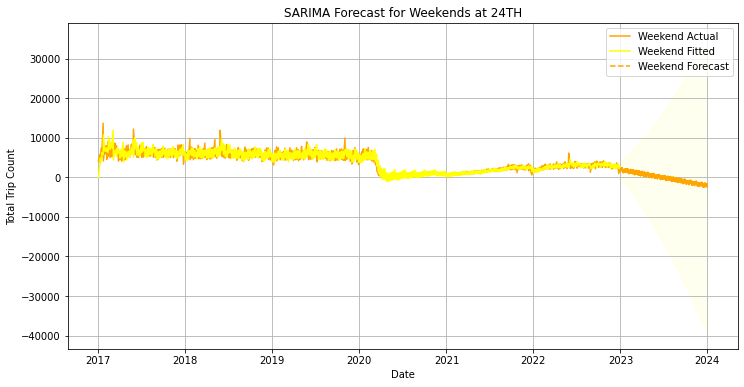

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


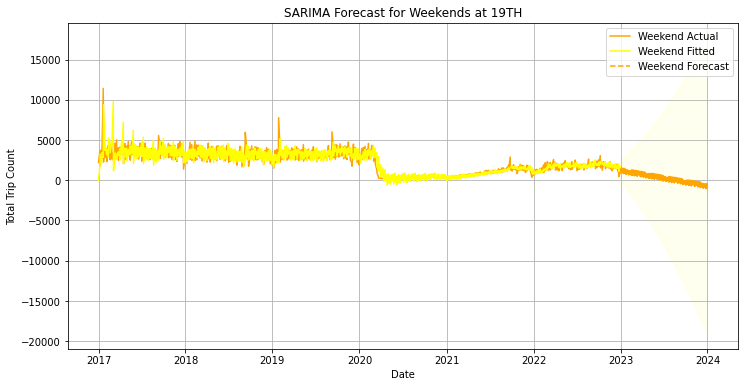

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


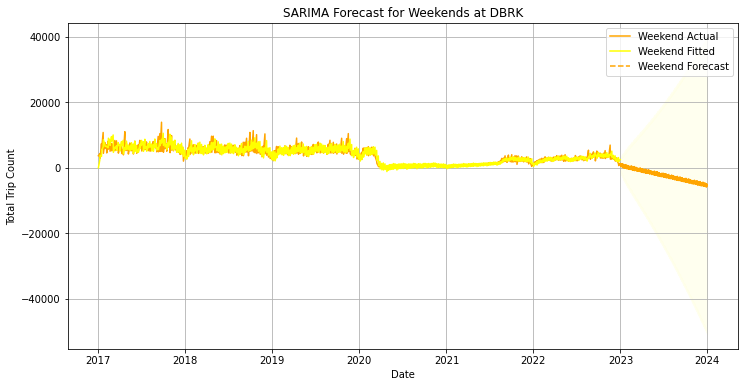

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


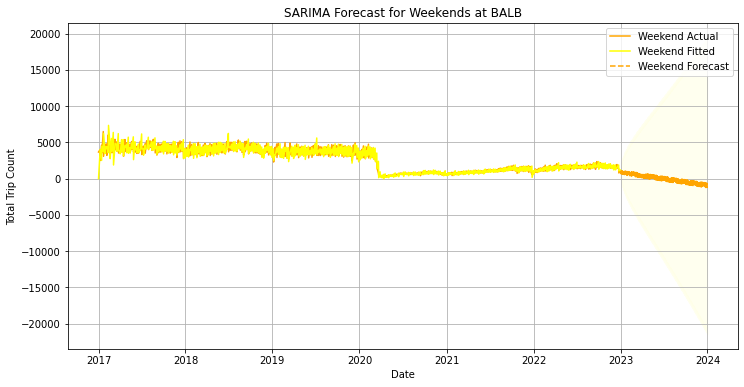

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofweek, when, to_date
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("BART Ridership Analysis") \
    .getOrCreate()


file_paths = [
    "/FileStore/tables/bart2017-1.csv",
    "/FileStore/tables/bart2018-1.csv",
    "/FileStore/tables/bart2019-1.csv",
    "/FileStore/tables/bart2020-1.csv",
    "/FileStore/tables/bart2021-3.csv",
    "/FileStore/tables/bart2022-2.csv"
]


df_list = [spark.read.csv(file_path, header=True, inferSchema=True) for file_path in file_paths]
df = df_list[0]
for other_df in df_list[1:]:
    df = df.union(other_df)


df = df.withColumn("Date", to_date(col("Date")))


df = df.withColumn("Day_of_Week", dayofweek(col("Date")))


df = df.withColumn("Day_Type", when(col("Day_of_Week").isin([1, 7]), "Weekend").otherwise("Weekday"))


daily_station_counts = df.groupBy("Date", "Destination Station").agg({"Trip Count": "sum"}) \
    .withColumnRenamed("sum(Trip Count)", "Total_Trip_Count")


top_stations = daily_station_counts.groupBy("Destination Station") \
    .agg({"Total_Trip_Count": "sum"}).orderBy(col("sum(Total_Trip_Count)").desc()).limit(10).toPandas()

top_station_names = top_stations['Destination Station'].tolist()


top_daily_counts = daily_station_counts.filter(col("Destination Station").isin(top_station_names)).toPandas()


day_type_df = df.select("Date", "Destination Station", "Day_Type").distinct().toPandas()
top_daily_counts = pd.merge(top_daily_counts, day_type_df, on=["Date", "Destination Station"], how="left")


top_daily_counts.set_index('Date', inplace=True)
top_daily_counts = top_daily_counts.sort_index()


weekend_counts = top_daily_counts[top_daily_counts['Day_Type'] == 'Weekend']


results_weekend = {}
for station in top_station_names:

    weekend_data = weekend_counts[weekend_counts['Destination Station'] == station]['Total_Trip_Count']
    model_weekend = SARIMAX(weekend_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results_weekend[station] = model_weekend.fit(disp=False)


forecast_horizon = 365  


for station in top_station_names:

    weekend_data = weekend_counts[weekend_counts['Destination Station'] == station]['Total_Trip_Count']
    

    plt.figure(figsize=(12, 6))


    plt.plot(weekend_data.index, weekend_data.values, label='Weekend Actual', color='orange')


    weekend_fitted = results_weekend[station].fittedvalues
    plt.plot(weekend_data.index, weekend_fitted, label='Weekend Fitted', color='yellow')


    weekend_forecast = results_weekend[station].get_forecast(steps=forecast_horizon)
    forecast_index_weekend = pd.date_range(start=weekend_data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
    forecast_values_weekend = weekend_forecast.predicted_mean
    conf_int_weekend = weekend_forecast.conf_int()


    plt.plot(forecast_index_weekend, forecast_values_weekend, label='Weekend Forecast', color='orange', linestyle='dashed')


    plt.fill_between(forecast_index_weekend, conf_int_weekend.iloc[:, 0], conf_int_weekend.iloc[:, 1], color='lightyellow', alpha=0.5)


    plt.title(f'SARIMA Forecast for Weekends at {station}')
    plt.xlabel('Date')
    plt.ylabel('Total Trip Count')
    plt.legend()
    plt.grid()
    
  
    plt.show()


Trend

<command-1180376878772684>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_monthly_totals_df['Year-Month'] = pd.to_datetime(top_monthly_totals_df[['Year', 'Month']].assign(Day=1))


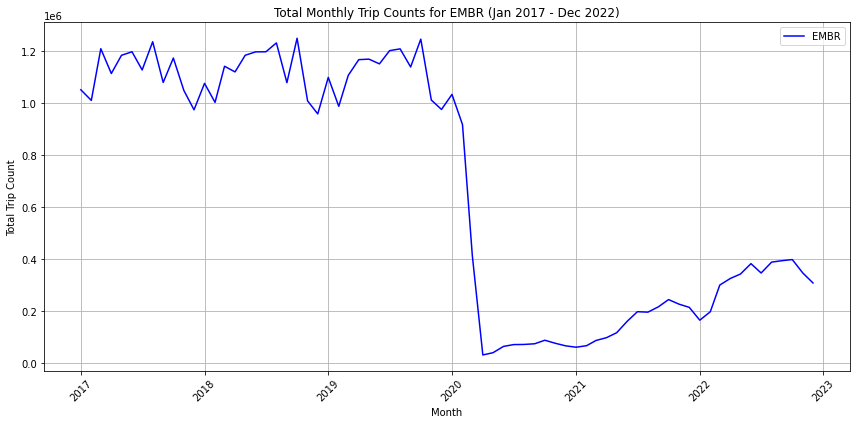

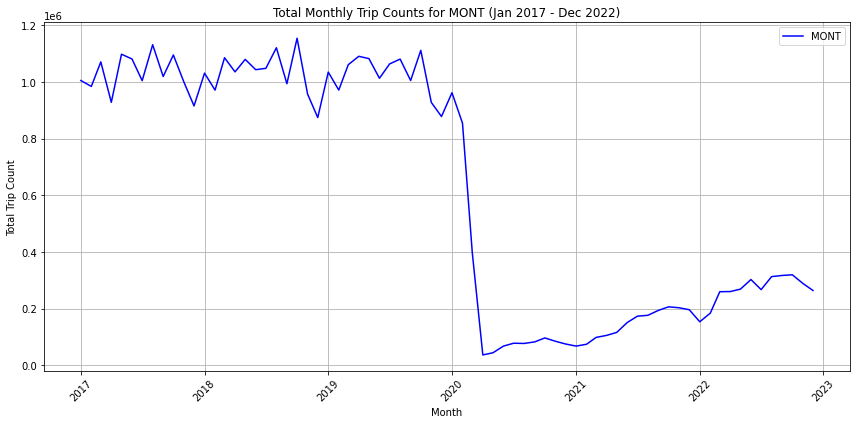

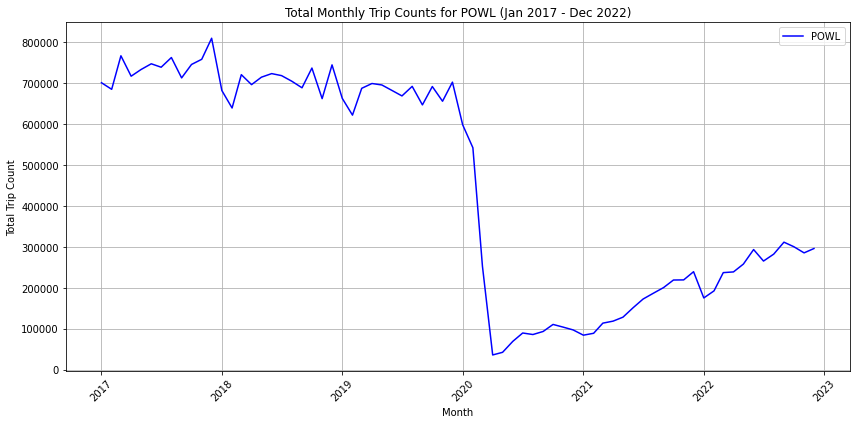

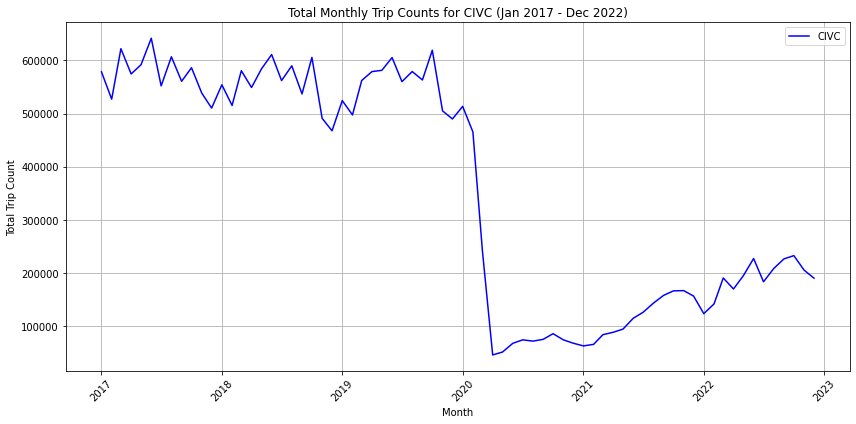

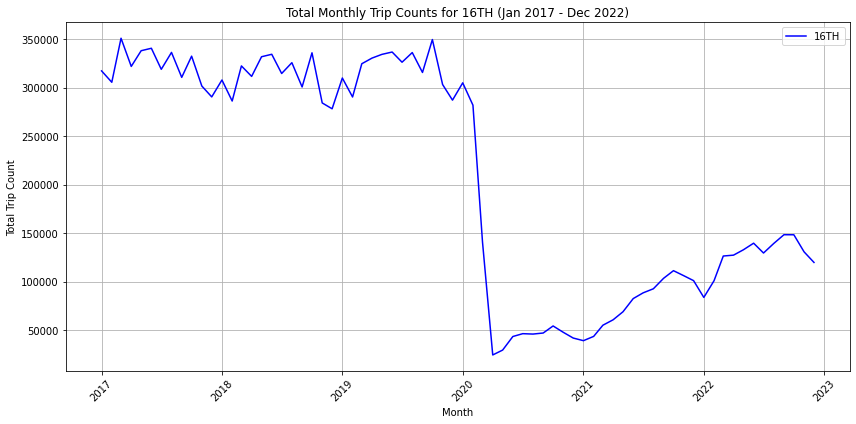

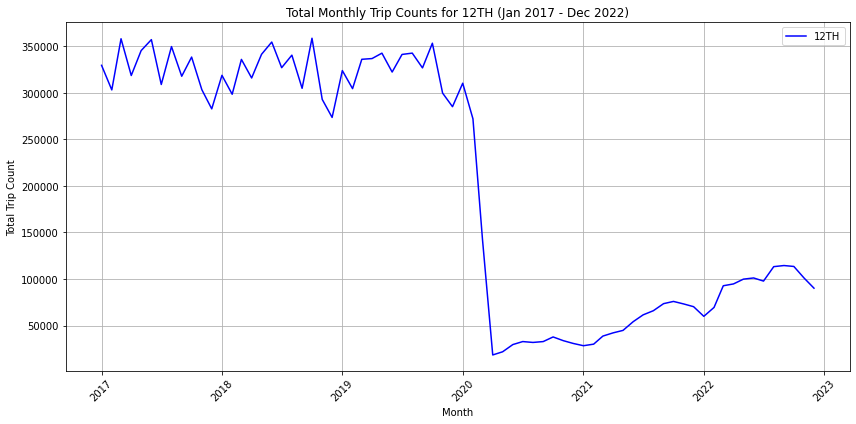

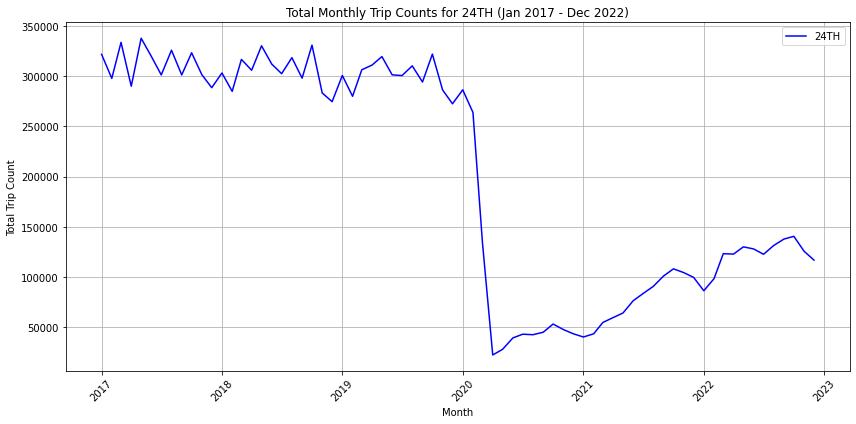

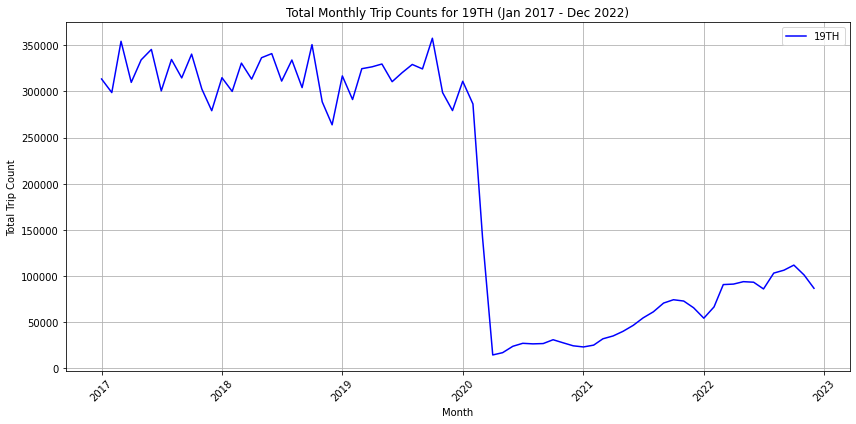

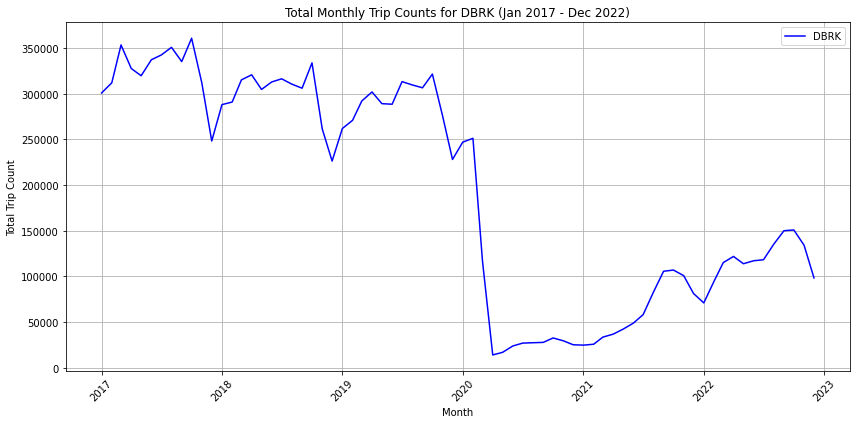

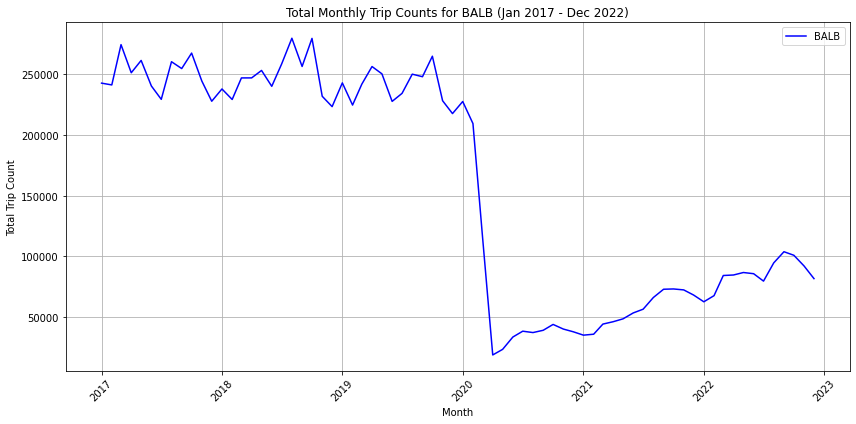

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, to_date
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("BART Ridership Analysis") \
    .getOrCreate()


file_paths = [
    "/FileStore/tables/bart2017-1.csv",
    "/FileStore/tables/bart2018-1.csv",
    "/FileStore/tables/bart2019-1.csv",
    "/FileStore/tables/bart2020-1.csv",
    "/FileStore/tables/bart2021-3.csv",
    "/FileStore/tables/bart2022-2.csv"
]


combined_df = None


for file_path in file_paths:
    df_year = spark.read.csv(file_path, header=True, inferSchema=True)
    if combined_df is None:
        combined_df = df_year
    else:
        combined_df = combined_df.union(df_year)


combined_df = combined_df.withColumn("Date", to_date(col("Date")))
combined_df = combined_df.withColumn("Year", year(col("Date")))
combined_df = combined_df.withColumn("Month", month(col("Date")))


monthly_totals = combined_df.groupBy("Year", "Month", "Destination Station").agg({"Trip Count": "sum"}) \
    .withColumnRenamed("sum(Trip Count)", "Monthly_Total_Trip_Count")


monthly_totals_df = monthly_totals.toPandas()


top_stations = monthly_totals_df.groupby("Destination Station")["Monthly_Total_Trip_Count"].sum().nlargest(10).index


top_monthly_totals_df = monthly_totals_df[monthly_totals_df["Destination Station"].isin(top_stations)]


top_monthly_totals_df['Year-Month'] = pd.to_datetime(top_monthly_totals_df[['Year', 'Month']].assign(Day=1))


top_monthly_totals_df = top_monthly_totals_df.sort_values(by="Year-Month")


for station in top_stations:
    plt.figure(figsize=(12, 6))
    station_data = top_monthly_totals_df[top_monthly_totals_df["Destination Station"] == station]
    plt.plot(station_data['Year-Month'], station_data['Monthly_Total_Trip_Count'], label=station, color='blue')
    
    plt.title(f'Total Monthly Trip Counts for {station} (Jan 2017 - Dec 2022)')
    plt.xlabel('Month')
    plt.ylabel('Total Trip Count')
    plt.xticks(rotation=45)  
    plt.grid()
    plt.legend()
    plt.tight_layout()  
    plt.show()





<command-1180376878772687>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_monthly_totals_df['Year-Month'] = pd.to_datetime(top_monthly_totals_df[['Year', 'Month']].assign(Day=1))


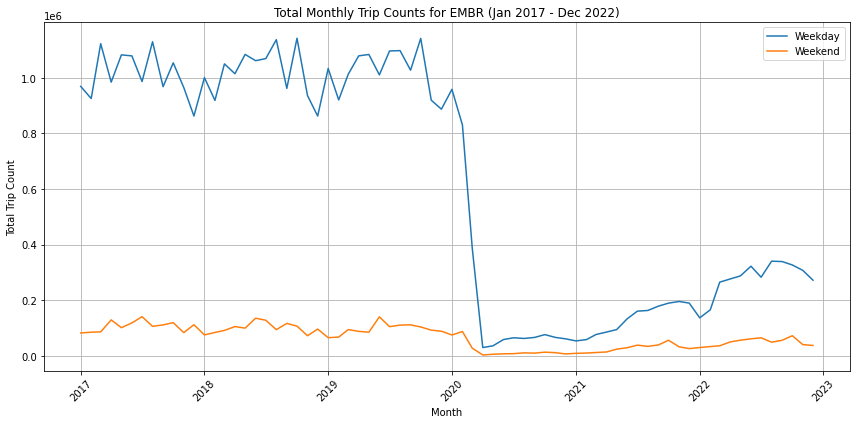

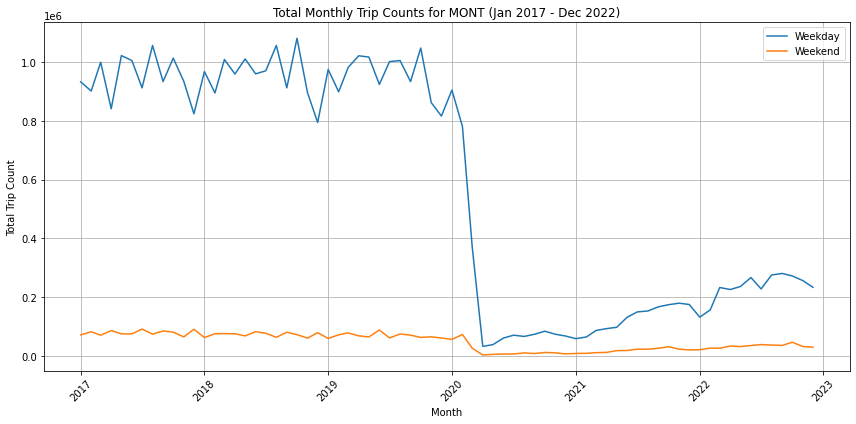

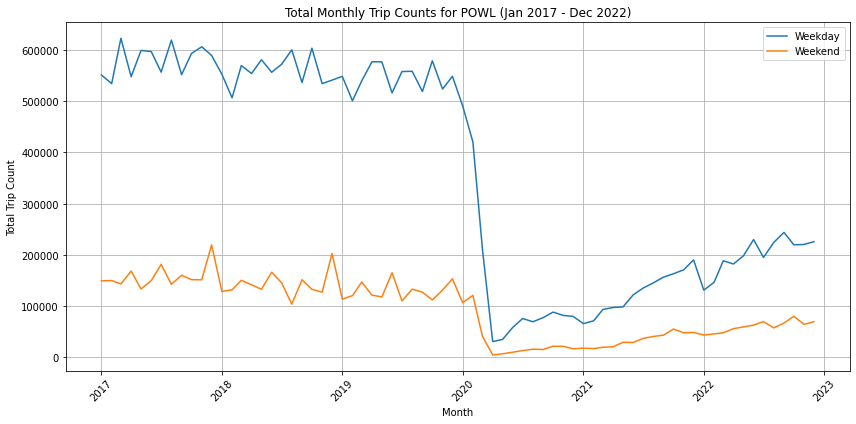

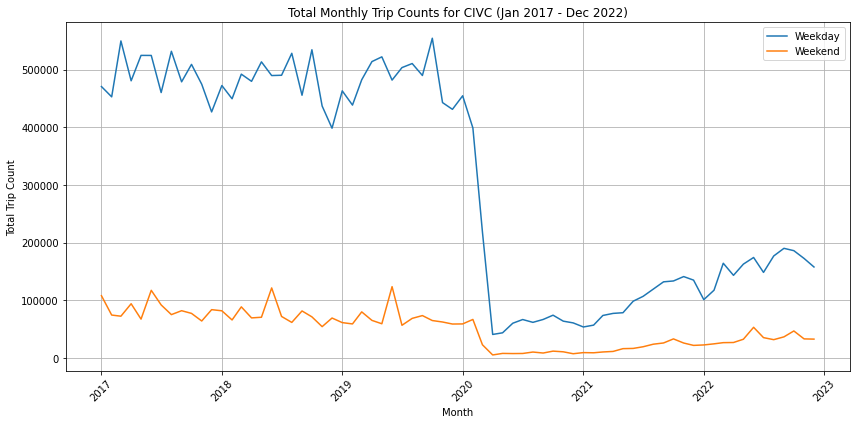

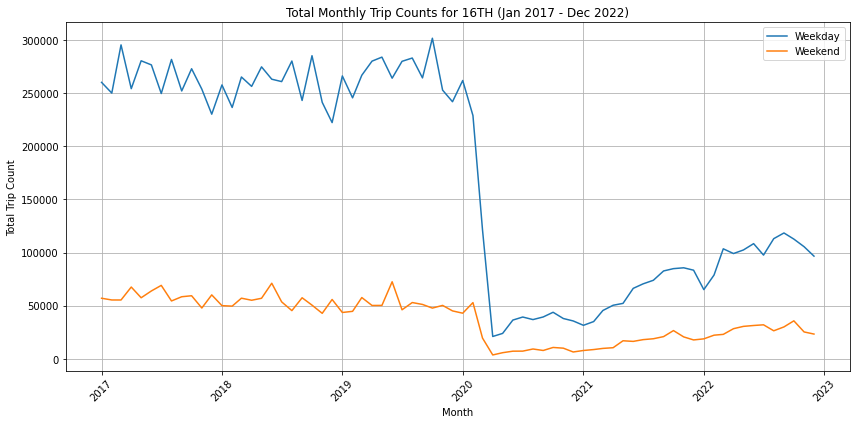

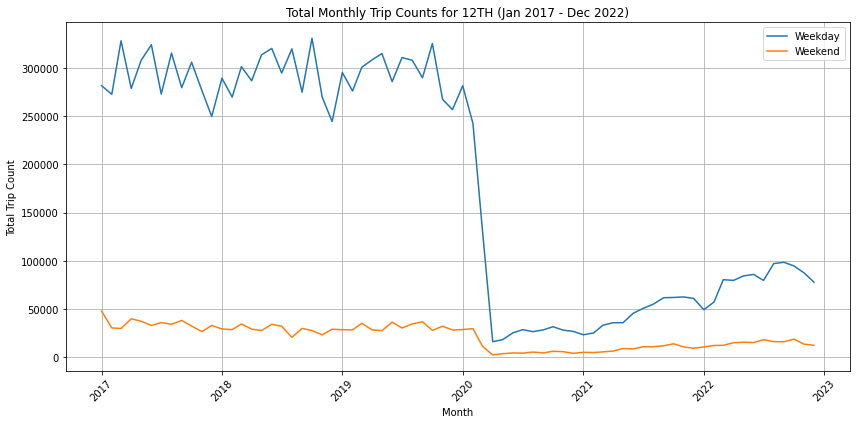

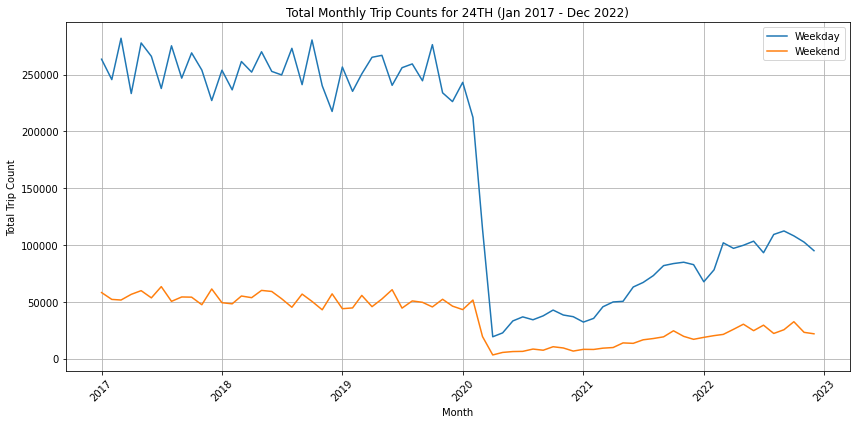

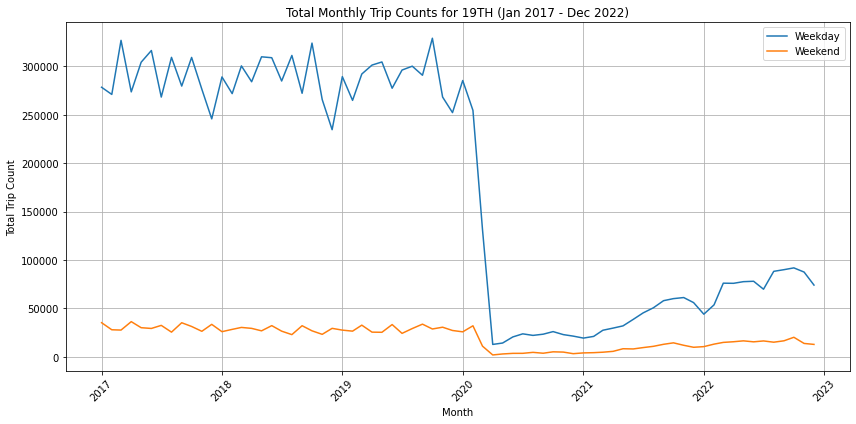

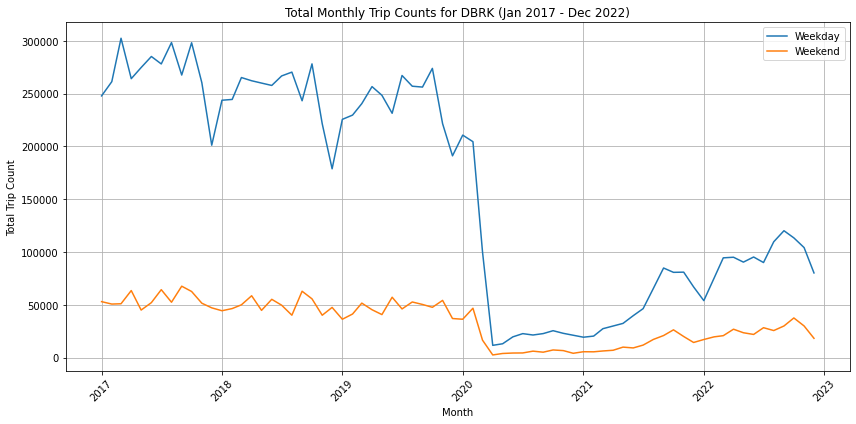

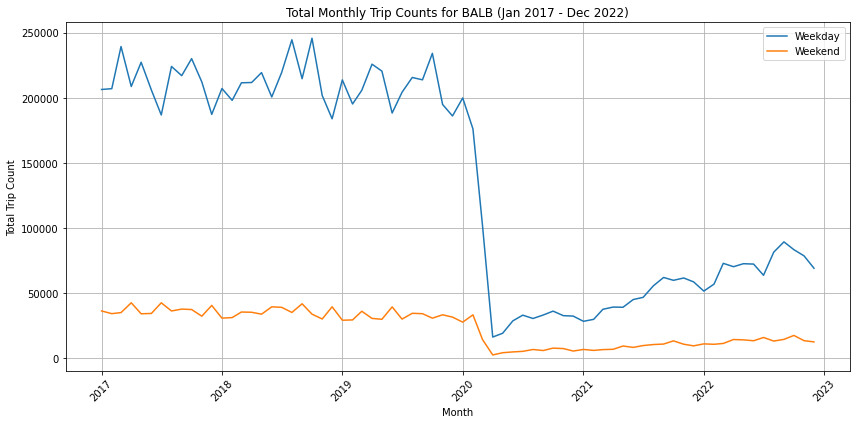

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, to_date, dayofweek, when
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("BART Ridership Analysis") \
    .getOrCreate()


file_paths = [
    "/FileStore/tables/bart2017-1.csv",
    "/FileStore/tables/bart2018-1.csv",
    "/FileStore/tables/bart2019-1.csv",
    "/FileStore/tables/bart2020-1.csv",
    "/FileStore/tables/bart2021-3.csv",
    "/FileStore/tables/bart2022-2.csv"
]


combined_df = None
for file_path in file_paths:
    df_year = spark.read.csv(file_path, header=True, inferSchema=True)
    if combined_df is None:
        combined_df = df_year
    else:
        combined_df = combined_df.union(df_year)


combined_df = combined_df.withColumn("Date", to_date(col("Date")))
combined_df = combined_df.withColumn("Year", year(col("Date")))
combined_df = combined_df.withColumn("Month", month(col("Date")))


combined_df = combined_df.withColumn("DayOfWeek", dayofweek(col("Date")))


combined_df = combined_df.withColumn(
    "TripType",
    when(col("DayOfWeek").isin(2, 3, 4, 5, 6), "Weekday")  
    .otherwise("Weekend")  
)


monthly_totals = combined_df.groupBy("Year", "Month", "TripType", "Destination Station").agg({"Trip Count": "sum"}) \
    .withColumnRenamed("sum(Trip Count)", "Monthly_Total_Trip_Count")


monthly_totals_df = monthly_totals.toPandas()


top_stations = monthly_totals_df.groupby("Destination Station")["Monthly_Total_Trip_Count"].sum().nlargest(10).index


top_monthly_totals_df = monthly_totals_df[monthly_totals_df["Destination Station"].isin(top_stations)]


top_monthly_totals_df['Year-Month'] = pd.to_datetime(top_monthly_totals_df[['Year', 'Month']].assign(Day=1))


top_monthly_totals_df = top_monthly_totals_df.sort_values(by="Year-Month")


for station in top_stations:
    plt.figure(figsize=(12, 6))

 
    station_data = top_monthly_totals_df[top_monthly_totals_df["Destination Station"] == station]
    
    
    for trip_type in ['Weekday', 'Weekend']:
        trip_data = station_data[station_data['TripType'] == trip_type]
        plt.plot(trip_data['Year-Month'], trip_data['Monthly_Total_Trip_Count'], label=trip_type)

    
    plt.title(f'Total Monthly Trip Counts for {station} (Jan 2017 - Dec 2022)')
    plt.xlabel('Month')
    plt.ylabel('Total Trip Count')
    plt.xticks(rotation=45)  
    plt.grid()
    plt.legend()
    plt.tight_layout()  
    plt.show()


Trend forecast

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

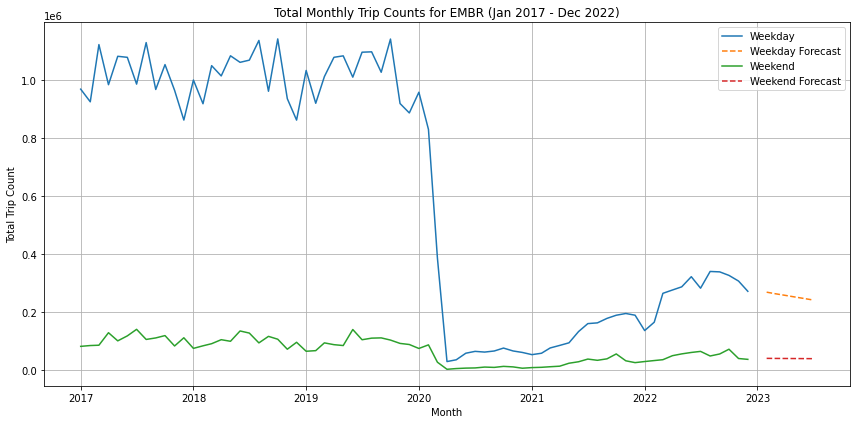

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

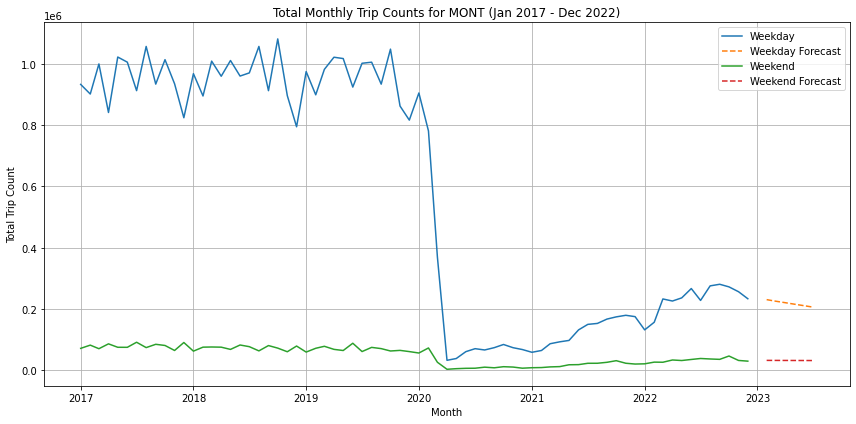

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

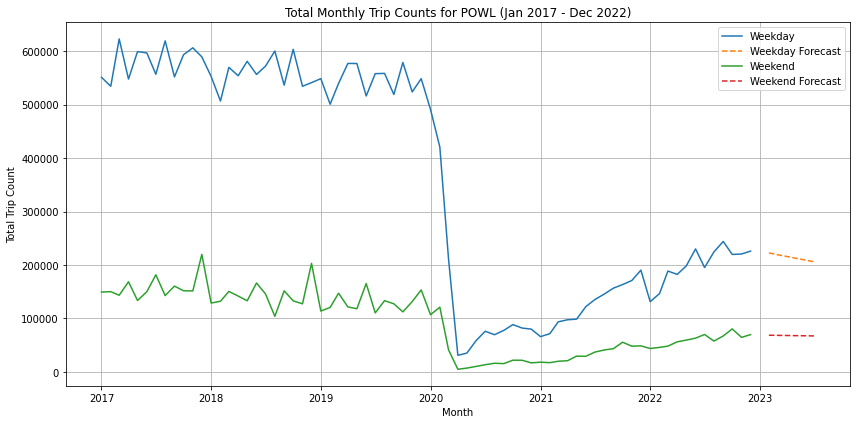

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

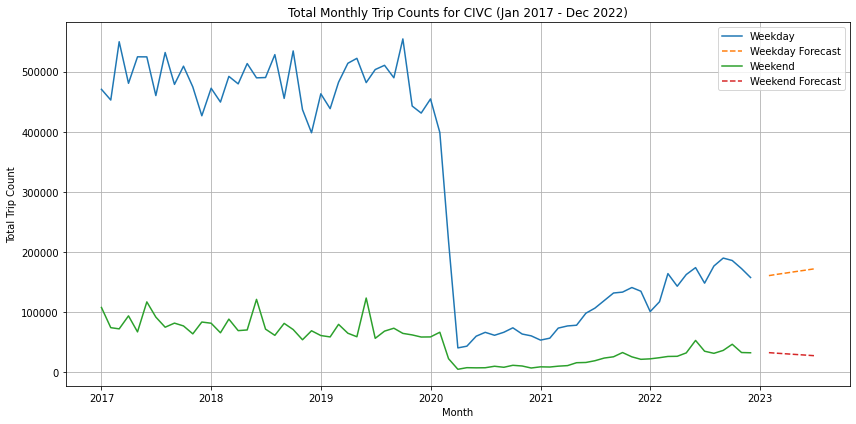

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

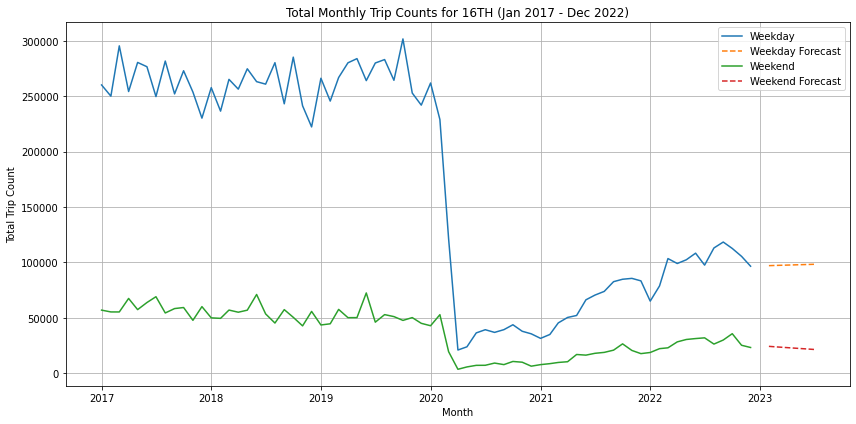

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

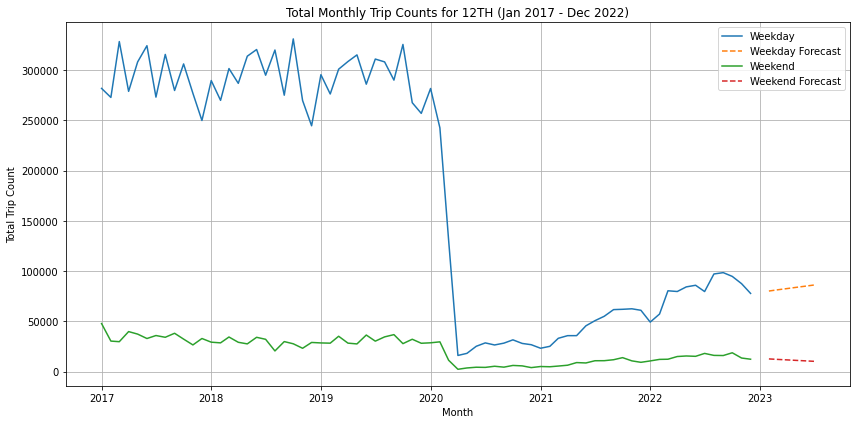

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

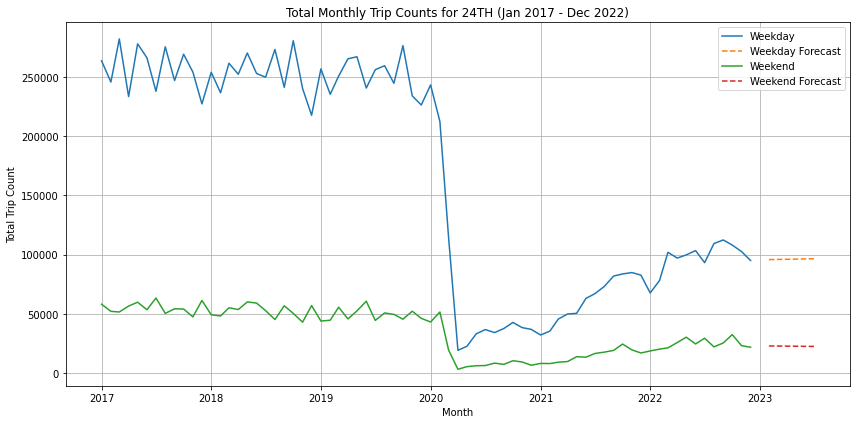

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

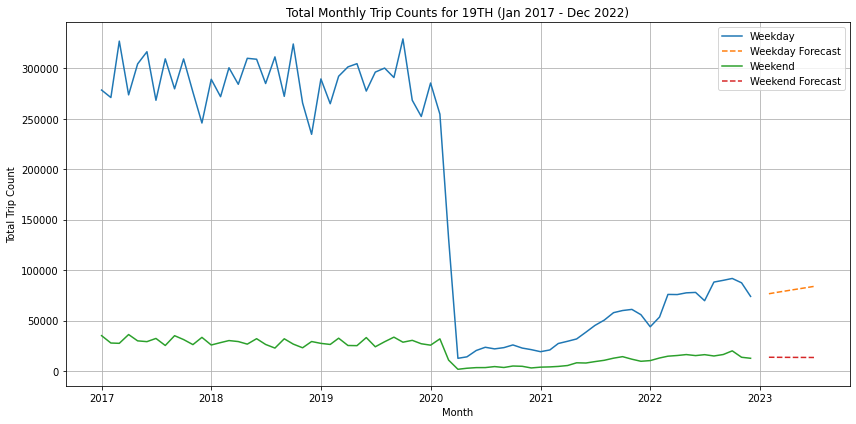

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

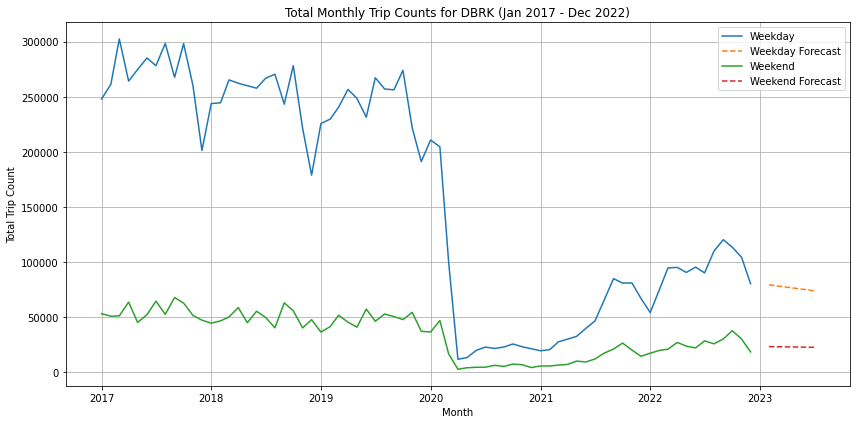

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  

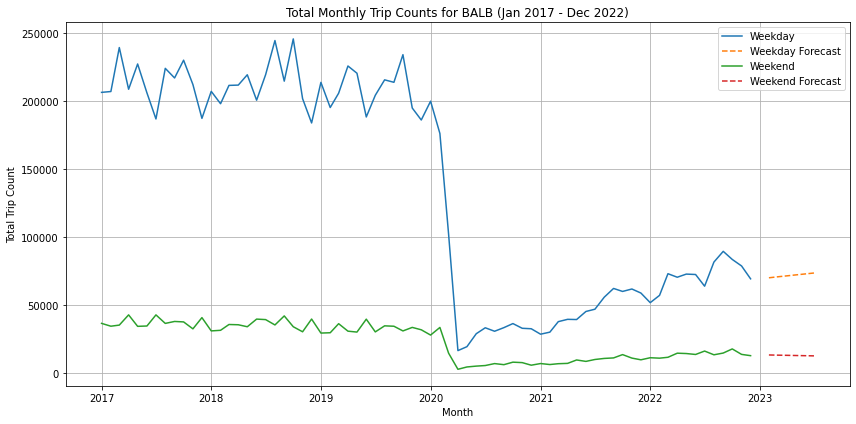

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, to_date, dayofweek, when
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


spark = SparkSession.builder \
    .appName("BART Ridership Analysis") \
    .getOrCreate()


file_paths = [
    "/FileStore/tables/bart2017-1.csv",
    "/FileStore/tables/bart2018-1.csv",
    "/FileStore/tables/bart2019-1.csv",
    "/FileStore/tables/bart2020-1.csv",
    "/FileStore/tables/bart2021-3.csv",
    "/FileStore/tables/bart2022-2.csv"
]


combined_df = None
for file_path in file_paths:
    df_year = spark.read.csv(file_path, header=True, inferSchema=True)
    if combined_df is None:
        combined_df = df_year
    else:
        combined_df = combined_df.union(df_year)


combined_df = combined_df.withColumn("Date", to_date(col("Date")))


combined_df = combined_df.withColumn("Year", year(col("Date"))) \
                          .withColumn("Month", month(col("Date")))


combined_df = combined_df.withColumn("DayOfWeek", dayofweek(col("Date")))


combined_df = combined_df.withColumn(
    "TripType",
    when(col("DayOfWeek").isin(2, 3, 4, 5, 6), "Weekday") 
    .otherwise("Weekend")  
)


monthly_totals = combined_df.groupBy("Year", "Month", "TripType", "Destination Station") \
    .agg({"Trip Count": "sum"}) \
    .withColumnRenamed("sum(Trip Count)", "Monthly_Total_Trip_Count")


monthly_totals_df = monthly_totals.toPandas().reset_index()


top_stations = monthly_totals_df.groupby("Destination Station")["Monthly_Total_Trip_Count"].sum().nlargest(10).index


top_monthly_totals_df = monthly_totals_df[monthly_totals_df["Destination Station"].isin(top_stations)].reset_index(drop=True)


top_monthly_totals_df['Year-Month'] = pd.to_datetime(top_monthly_totals_df[['Year', 'Month']].assign(Day=1))


top_monthly_totals_df = top_monthly_totals_df.sort_values(by="Year-Month")


for station in top_stations:
    plt.figure(figsize=(12, 6))

   
    station_data = top_monthly_totals_df[top_monthly_totals_df["Destination Station"] == station]

    
    for trip_type in ['Weekday', 'Weekend']:
        trip_data = station_data[station_data['TripType'] == trip_type]
        plt.plot(trip_data['Year-Month'], trip_data['Monthly_Total_Trip_Count'], label=trip_type)

        
        model = ExponentialSmoothing(trip_data['Monthly_Total_Trip_Count'], trend='add', seasonal=None)
        model_fit = model.fit()

        
        forecast = model_fit.forecast(steps=6)
        future_dates = pd.date_range(start=trip_data['Year-Month'].max() + pd.DateOffset(months=1), periods=6, freq='M')

        
        plt.plot(future_dates, forecast, label=f'{trip_type} Forecast', linestyle='--')

    plt.title(f'Total Monthly Trip Counts for {station} (Jan 2017 - Dec 2022)')
    plt.xlabel('Month')
    plt.ylabel('Total Trip Count')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()



ทดสอบความแม่นยำ (MAPE)

In [0]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofweek, when, to_date
from statsmodels.tsa.statespace.sarimax import SARIMAX

spark = SparkSession.builder \
    .appName("BART Ridership Analysis") \
    .getOrCreate()

file_paths = [
    "/FileStore/tables/bart2017-1.csv",
    "/FileStore/tables/bart2018-1.csv",
    "/FileStore/tables/bart2019-1.csv",
    "/FileStore/tables/bart2020-1.csv",
    "/FileStore/tables/bart2021-3.csv",
    "/FileStore/tables/bart2022-2.csv"
]

df_list = [spark.read.csv(file_path, header=True, inferSchema=True) for file_path in file_paths]
df = df_list[0]
for other_df in df_list[1:]:
    df = df.union(other_df)

df = df.withColumn("Date", to_date(col("Date")))

df = df.withColumn("Day_of_Week", dayofweek(col("Date")))

df = df.withColumn("Day_Type", when(col("Day_of_Week").isin([1, 7]), "Weekend").otherwise("Weekday"))

daily_station_counts = df.groupBy("Date", "Destination Station").agg({"Trip Count": "sum"}) \
    .withColumnRenamed("sum(Trip Count)", "Total_Trip_Count")

top_stations = daily_station_counts.groupBy("Destination Station") \
    .agg({"Total_Trip_Count": "sum"}).orderBy(col("sum(Total_Trip_Count)").desc()).limit(10).toPandas()

top_station_names = top_stations['Destination Station'].tolist()

top_daily_counts = daily_station_counts.filter(col("Destination Station").isin(top_station_names)).toPandas()

day_type_df = df.select("Date", "Destination Station", "Day_Type").distinct().toPandas()
top_daily_counts = pd.merge(top_daily_counts, day_type_df, on=["Date", "Destination Station"], how="left")

top_daily_counts.set_index('Date', inplace=True)
top_daily_counts = top_daily_counts.sort_index()

weekday_counts = top_daily_counts[top_daily_counts['Day_Type'] == 'Weekday']
weekend_counts = top_daily_counts[top_daily_counts['Day_Type'] == 'Weekend']

model_fit_summary = []

for station in top_station_names:
    weekday_data = weekday_counts[weekday_counts['Destination Station'] == station]['Total_Trip_Count']
    model_weekday = SARIMAX(weekday_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fitted_weekday = model_weekday.fit(disp=False)
    
    predicted_weekday = fitted_weekday.fittedvalues
    actual_weekday = weekday_data
    

    weekday_mape = np.mean(np.abs((actual_weekday - predicted_weekday) / actual_weekday)) * 100
    
    weekend_data = weekend_counts[weekend_counts['Destination Station'] == station]['Total_Trip_Count']
    model_weekend = SARIMAX(weekend_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fitted_weekend = model_weekend.fit(disp=False)
    
    predicted_weekend = fitted_weekend.fittedvalues
    actual_weekend = weekend_data
    
    weekend_mape = np.mean(np.abs((actual_weekend - predicted_weekend) / actual_weekend)) * 100
    

    model_fit_summary.append({
        'Station': station,
        'Type': 'Weekday',
        'MAPE': weekday_mape
    })
    model_fit_summary.append({
        'Station': station,
        'Type': 'Weekend',
        'MAPE': weekend_mape
    })

model_fit_df = pd.DataFrame(model_fit_summary)

print(model_fit_df)


/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(date

   Station     Type       MAPE
0     EMBR  Weekday  24.271583
1     EMBR  Weekend  53.774198
2     MONT  Weekday  25.647370
3     MONT  Weekend  41.052933
4     POWL  Weekday  12.389678
5     POWL  Weekend  35.937347
6     CIVC  Weekday  18.721099
7     CIVC  Weekend  49.447916
8     16TH  Weekday  14.124601
9     16TH  Weekend  32.191947
10    12TH  Weekday  20.884648
11    12TH  Weekend  27.764988
12    24TH  Weekday  12.598219
13    24TH  Weekend  27.846517
14    19TH  Weekday  26.182888
15    19TH  Weekend  32.535255
16    DBRK  Weekday  15.421243
17    DBRK  Weekend  37.160508
18    BALB  Weekday  13.199884
19    BALB  Weekend  12.081219
